<a href="https://colab.research.google.com/github/KeerthiKamarthi/html_file/blob/main/COCO_Image_Viewer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="markdown-google-sans">
  <h1>Welcome to Colab!</h1>
</div>

If you're already familiar with Colab, check out this video to learn about interactive tables, the executed code history view, and the command palette.

<center>
  <a href="https://www.youtube.com/watch?v=rNgswRZ2C1Y" target="_blank">
  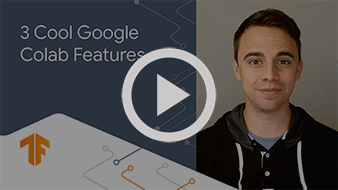
  </a>
</center>

<div class="markdown-google-sans">
  <h1>What is Colab?</h1>
</div>

Colab, or "Colaboratory", allows you to write and execute Python in your browser, with 
- Zero configuration required
- Access to GPUs free of charge
- Easy sharing

Whether you're a **student**, a **data scientist** or an **AI researcher**, Colab can make your work easier. Watch [Introduction to Colab](https://www.youtube.com/watch?v=inN8seMm7UI) to learn more, or just get started below!

<div class="markdown-google-sans">

## **Getting started**
</div>

The document you are reading is not a static web page, but an interactive environment called a **Colab notebook** that lets you write and execute code.

For example, here is a **code cell** with a short Python script that computes a value, stores it in a variable, and prints the result:

In [ ]:
seconds_in_a_day = 24 * 60 * 60
seconds_in_a_day

86400

To execute the code in the above cell, select it with a click and then either press the play button to the left of the code, or use the keyboard shortcut "Command/Ctrl+Enter". To edit the code, just click the cell and start editing.

Variables that you define in one cell can later be used in other cells:

In [ ]:
seconds_in_a_week = 7 * seconds_in_a_day
seconds_in_a_week

604800

Colab notebooks allow you to combine **executable code** and **rich text** in a single document, along with **images**, **HTML**, **LaTeX** and more. When you create your own Colab notebooks, they are stored in your Google Drive account. You can easily share your Colab notebooks with co-workers or friends, allowing them to comment on your notebooks or even edit them. To learn more, see [Overview of Colab](/notebooks/basic_features_overview.ipynb). To create a new Colab notebook you can use the File menu above, or use the following link: [create a new Colab notebook](http://colab.research.google.com#create=true).

Colab notebooks are Jupyter notebooks that are hosted by Colab. To learn more about the Jupyter project, see [jupyter.org](https://www.jupyter.org).

<div class="markdown-google-sans">

## Data science
</div>

With Colab you can harness the full power of popular Python libraries to analyze and visualize data. The code cell below uses **numpy** to generate some random data, and uses **matplotlib** to visualize it. To edit the code, just click the cell and start editing.

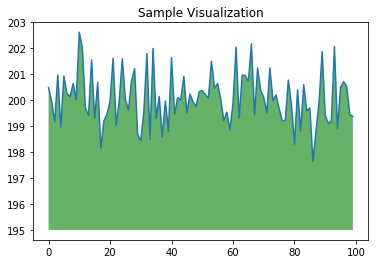

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

ys = 200 + np.random.randn(100)
x = [x for x in range(len(ys))]

plt.plot(x, ys, '-')
plt.fill_between(x, ys, 195, where=(ys > 195), facecolor='g', alpha=0.6)

plt.title("Sample Visualization")
plt.show()

You can import your own data into Colab notebooks from your Google Drive account, including from spreadsheets, as well as from Github and many other sources. To learn more about importing data, and how Colab can be used for data science, see the links below under [Working with Data](#working-with-data).

<div class="markdown-google-sans">

## Machine learning
</div>

With Colab you can import an image dataset, train an image classifier on it, and evaluate the model, all in just [a few lines of code](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb). Colab notebooks execute code on Google's cloud servers, meaning you can leverage the power of Google hardware, including [GPUs and TPUs](#using-accelerated-hardware), regardless of the power of your machine. All you need is a browser.

Colab is used extensively in the machine learning community with applications including:
- Getting started with TensorFlow
- Developing and training neural networks
- Experimenting with TPUs
- Disseminating AI research
- Creating tutorials

To see sample Colab notebooks that demonstrate machine learning applications, see the [machine learning examples](#machine-learning-examples) below.

<div class="markdown-google-sans">

## More Resources

### Working with Notebooks in Colab

</div>

- [Overview of Colaboratory](/notebooks/basic_features_overview.ipynb)
- [Guide to Markdown](/notebooks/markdown_guide.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Saving and loading notebooks in GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [Interactive forms](/notebooks/forms.ipynb)
- [Interactive widgets](/notebooks/widgets.ipynb)
- <img src="/img/new.png" height="20px" align="left" hspace="4px" alt="New"></img>

<div class="markdown-google-sans">

<a name="working-with-data"></a>
### Working with Data
</div>

- [Loading data: Drive, Sheets, and Google Cloud Storage](/notebooks/io.ipynb) 
- [Charts: visualizing data](/notebooks/charts.ipynb)
- [Getting started with BigQuery](/notebooks/bigquery.ipynb)

<div class="markdown-google-sans">

### Machine Learning Crash Course

<div>

These are a few of the notebooks from Google's online Machine Learning course. See the [full course website](https://developers.google.com/machine-learning/crash-course/) for more.
- [Intro to Pandas DataFrame](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [Linear regression with tf.keras using synthetic data](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)

<div class="markdown-google-sans">

<a name="using-accelerated-hardware"></a>
### Using Accelerated Hardware
</div>

- [TensorFlow with GPUs](/notebooks/gpu.ipynb)
- [TensorFlow with TPUs](/notebooks/tpu.ipynb)

<div class="markdown-google-sans">

<a name="machine-learning-examples"></a>

### Featured examples

</div>

- [NeMo Voice Swap](https://colab.research.google.com/github/NVIDIA/NeMo/blob/stable/tutorials/VoiceSwapSample.ipynb): Use Nvidia's NeMo conversational AI Toolkit to swap a voice in an audio fragment with a computer generated one.

- [Retraining an Image Classifier](https://tensorflow.org/hub/tutorials/tf2_image_retraining): Build a Keras model on top of a pre-trained image classifier to distinguish flowers.
- [Text Classification](https://tensorflow.org/hub/tutorials/tf2_text_classification): Classify IMDB movie reviews as either *positive* or *negative*.
- [Style Transfer](https://tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization): Use deep learning to transfer style between images.
- [Multilingual Universal Sentence Encoder Q&A](https://tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa): Use a machine learning model to answer questions from the SQuAD dataset.
- [Video Interpolation](https://tensorflow.org/hub/tutorials/tweening_conv3d): Predict what happened in a video between the first and the last frame.


In [76]:
import IPython
import os
import json
import random
import numpy as np
import requests
from io import BytesIO
from math import trunc
from PIL import Image as PILImage
from PIL import ImageDraw as PILImageDraw

In [77]:
# Load the dataset json
class CocoDataset():
    def __init__(self, annotation_path, image_dir):
        self.annotation_path = annotation_path
        self.image_dir = image_dir
        self.colors = ['blue', 'purple', 'red', 'green', 'orange', 'salmon', 'pink', 'gold',
                       'orchid', 'slateblue', 'limegreen', 'seagreen', 'darkgreen', 'olive',
                       'teal', 'aquamarine', 'steelblue', 'powderblue', 'dodgerblue', 'navy',
                       'magenta', 'sienna', 'maroon']

        json_file = open(self.annotation_path)
        self.coco = json.load(json_file)
        json_file.close()

        self.process_info()
        self.process_licenses()
        self.process_categories()
        self.process_images()
        self.process_segmentations()

    def display_info(self):
        print('Dataset Info:')
        print('=============')
        if self.info is None:
            return
        for key, item in self.info.items():
            print('  {}: {}'.format(key, item))

        requirements = [['description', str],
                        ['url', str],
                        ['version', str],
                        ['year', int],
                        ['contributor', str],
                        ['date_created', str]]
        for req, req_type in requirements:
            if req not in self.info:
                print('ERROR: {} is missing'.format(req))
            elif type(self.info[req]) != req_type:
                print('ERROR: {} should be type {}'.format(req, str(req_type)))
        print('')

    def display_licenses(self):
        print('Licenses:')
        print('=========')

        if self.licenses is None:
            return
        requirements = [['id', int],
                        ['url', str],
                        ['name', str]]
        for license in self.licenses:
            for key, item in license.items():
                print('  {}: {}'.format(key, item))
            for req, req_type in requirements:
                if req not in license:
                    print('ERROR: {} is missing'.format(req))
                elif type(license[req]) != req_type:
                    print('ERROR: {} should be type {}'.format(
                        req, str(req_type)))
            print('')
        print('')

    def display_categories(self):
        print('Categories:')
        print('=========')
        for sc_key, sc_val in self.super_categories.items():
            print('  super_category: {}'.format(sc_key))
            for cat_id in sc_val:
                print('    id {}: {}'.format(
                    cat_id, self.categories[cat_id]['name']))
            print('')

    def display_image(self, image_id, show_polys=True, show_bbox=True, show_crowds=True, use_url=False):
        print('Image:')
        print('======')
        if image_id == 'random':
            image_id = random.choice(list(self.images.keys()))

        # Print the image info
        image = self.images[image_id]
        for key, val in image.items():
            print('  {}: {}'.format(key, val))

        # Open the image
        if use_url:
            image_path = image['coco_url']
            response = requests.get(image_path)
            image = PILImage.open(BytesIO(response.content))

        else:
            # image_path = os.path.join(self.image_dir, image['file_name'])
            image_path = "{}/{}".format(self.image_dir, image['file_name'])
            image = PILImage.open(image_path)

        # Calculate the size and adjusted display size
        max_width = 600
        image_width, image_height = image.size
        adjusted_width = min(image_width, max_width)
        adjusted_ratio = adjusted_width / image_width
        adjusted_height = adjusted_ratio * image_height

        # Create list of polygons to be drawn
        polygons = {}
        bbox_polygons = {}
        rle_regions = {}
        poly_colors = {}
        bbox_categories = {}
        print('  segmentations ({}):'.format(
            len(self.segmentations[image_id])))
        for i, segm in enumerate(self.segmentations[image_id]):
            polygons_list = []
            if segm['iscrowd'] != 0:
                # Gotta decode the RLE
                px = 0
                x, y = 0, 0
                rle_list = []
                for j, counts in enumerate(segm['segmentation']['counts']):
                    if j % 2 == 0:
                        # Empty pixels
                        px += counts
                    else:
                        # Need to draw on these pixels, since we are drawing in vector form,
                        # we need to draw horizontal lines on the image
                        x_start = trunc(
                            trunc(px / image_height) * adjusted_ratio)
                        y_start = trunc(px % image_height * adjusted_ratio)
                        px += counts
                        x_end = trunc(trunc(px / image_height)
                                      * adjusted_ratio)
                        y_end = trunc(px % image_height * adjusted_ratio)
                        if x_end == x_start:
                            # This is only on one line
                            rle_list.append(
                                {'x': x_start, 'y': y_start, 'width': 1, 'height': (y_end - y_start)})
                        if x_end > x_start:
                            # This spans more than one line
                            # Insert top line first
                            rle_list.append(
                                {'x': x_start, 'y': y_start, 'width': 1, 'height': (image_height - y_start)})

                            # Insert middle lines if needed
                            lines_spanned = x_end - x_start + 1  # total number of lines spanned
                            full_lines_to_insert = lines_spanned - 2
                            if full_lines_to_insert > 0:
                                full_lines_to_insert = trunc(
                                    full_lines_to_insert * adjusted_ratio)
                                rle_list.append(
                                    {'x': (x_start + 1), 'y': 0, 'width': full_lines_to_insert, 'height': image_height})

                            # Insert bottom line
                            rle_list.append(
                                {'x': x_end, 'y': 0, 'width': 1, 'height': y_end})
                if len(rle_list) > 0:
                    rle_regions[segm['id']] = rle_list
            else:
                # Add the polygon segmentation
                for segmentation_points in segm['segmentation']:
                    segmentation_points = np.multiply(
                        segmentation_points, adjusted_ratio).astype(int)
                    polygons_list.append(
                        str(segmentation_points).lstrip('[').rstrip(']'))
            polygons[segm['id']] = polygons_list
            if i < len(self.colors):
                poly_colors[segm['id']] = self.colors[i]
            else:
                poly_colors[segm['id']] = 'white'

            bbox = segm['bbox']
            bbox_points = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1],
                           bbox[0] + bbox[2], bbox[1] +
                           bbox[3], bbox[0], bbox[1] + bbox[3],
                           bbox[0], bbox[1]]
            bbox_points = np.multiply(bbox_points, adjusted_ratio).astype(int)
            bbox_polygons[segm['id']] = str(
                bbox_points).lstrip('[').rstrip(']')
            bbox_categories[segm['id']] = self.categories[segm['category_id']]
            # Print details
            print('    {}:{}:{}'.format(
                segm['id'], poly_colors[segm['id']], self.categories[segm['category_id']]))

        # Draw segmentation polygons on image
        html = '<div class="container" style="position:relative;">'
        html += '<img src="{}" style="position:relative;top:0px;left:0px;width:{}px;">'.format(
            image_path, adjusted_width)
        html += '<div class="svgclass"><svg width="{}" height="{}">'.format(
            adjusted_width, adjusted_height)

        if show_polys:
            for seg_id, points_list in polygons.items():
                fill_color = poly_colors[seg_id]
                stroke_color = poly_colors[seg_id]
                for points in points_list:
                    html += '<polygon points="{}" style="fill:{}; stroke:{}; stroke-width:1; fill-opacity:0.5" />'.format(
                        points, fill_color, stroke_color)

        if show_crowds:
            for seg_id, rect_list in rle_regions.items():
                fill_color = poly_colors[seg_id]
                stroke_color = poly_colors[seg_id]
                for rect_def in rect_list:
                    x, y = rect_def['x'], rect_def['y']
                    w, h = rect_def['width'], rect_def['height']
                    html += '<rect x="{}" y="{}" width="{}" height="{}" style="fill:{}; stroke:{}; stroke-width:1; fill-opacity:0.5; stroke-opacity:0.5" />'.format(
                        x, y, w, h, fill_color, stroke_color)

        if show_bbox:
            for seg_id, points in bbox_polygons.items():
                x, y = [int(i) for i in points.split()[:2]]
                html += '<text x="{}" y="{}" fill="yellow">{}</text>'.format(
                    x, y, bbox_categories[seg_id]["name"])
                fill_color = poly_colors[seg_id]
                stroke_color = poly_colors[seg_id]
                html += '<polygon points="{}" style="fill:{}; stroke:{}; stroke-width:1; fill-opacity:0" />'.format(
                    points, fill_color, stroke_color)

        html += '</svg></div>'
        html += '</div>'
        html += '<style>'
        html += '.svgclass { position:absolute; top:0px; left:0px;}'
        html += '</style>'
        return html

    def process_info(self):
        self.info = self.coco.get('info')

    def process_licenses(self):
        self.licenses = self.coco.get('licenses')

    def process_categories(self):
        self.categories = {}
        self.super_categories = {}
        for category in self.coco['categories']:
            cat_id = category['id']
            super_category = category['supercategory']

            # Add category to the categories dict
            if cat_id not in self.categories:
                self.categories[cat_id] = category
            else:
                print("ERROR: Skipping duplicate category id: {}".format(category))

            # Add category to super_categories dict
            if super_category not in self.super_categories:
                # Create a new set with the category id
                self.super_categories[super_category] = {cat_id}
            else:
                self.super_categories[super_category] |= {
                    cat_id}  # Add category id to the set

    def process_images(self):
        self.images = {}
        for image in self.coco['images']:
            image_id = image['id']
            if image_id in self.images:
                print("ERROR: Skipping duplicate image id: {}".format(image))
            else:
                self.images[image_id] = image

    def process_segmentations(self):
        self.segmentations = {}
        for segmentation in self.coco['annotations']:
            image_id = segmentation['image_id']
            if image_id not in self.segmentations:
                self.segmentations[image_id] = []
            self.segmentations[image_id].append(segmentation)

In [78]:
annotation_path = "trainval.json"
image_dir = "images"

coco_dataset = CocoDataset(annotation_path, image_dir)
coco_dataset.display_info()
coco_dataset.display_licenses()
coco_dataset.display_categories()

Dataset Info:
Licenses:
Categories:
  super_category: bean
    id 0: bean

  super_category: card
    id 1: card



In [82]:
for k, v in coco_dataset.images.items():
    print(k, v)

0 {'height': 3000, 'width': 4000, 'id': 0, 'file_name': '75bade50-1672664670088.jpeg'}


In [83]:
html = coco_dataset.display_image(0, use_url=False)
IPython.display.HTML(html)

Image:
  height: 3000
  width: 4000
  id: 0
  file_name: 75bade50-1672664670088.jpeg
  segmentations (108):
    1:blue:{'supercategory': 'bean', 'id': 0, 'name': 'bean'}
    2:purple:{'supercategory': 'bean', 'id': 0, 'name': 'bean'}
    3:red:{'supercategory': 'bean', 'id': 0, 'name': 'bean'}
    4:green:{'supercategory': 'bean', 'id': 0, 'name': 'bean'}
    5:orange:{'supercategory': 'bean', 'id': 0, 'name': 'bean'}
    6:salmon:{'supercategory': 'bean', 'id': 0, 'name': 'bean'}
    7:pink:{'supercategory': 'bean', 'id': 0, 'name': 'bean'}
    8:gold:{'supercategory': 'bean', 'id': 0, 'name': 'bean'}
    9:orchid:{'supercategory': 'bean', 'id': 0, 'name': 'bean'}
    10:slateblue:{'supercategory': 'bean', 'id': 0, 'name': 'bean'}
    11:limegreen:{'supercategory': 'bean', 'id': 0, 'name': 'bean'}
    12:seagreen:{'supercategory': 'bean', 'id': 0, 'name': 'bean'}
    13:darkgreen:{'supercategory': 'bean', 'id': 0, 'name': 'bean'}
    14:olive:{'supercategory': 'bean', 'id': 0, 'name':